# Studies In Variational Inference

## Normal-Normal model with known variance

Suppose we have a sample of $n$ observations $y_i$ from the normal distribution. Supposing they are iid with mean $\mu$ and variance $\sigma^2$. Moreover, supposing that $\sigma^2$ is known, and that $\mu \sim \mathcal{N}(\mu_0, \tau_0^2)$, we know via conjugacy that
$$
\mu | \underbar{y} \sim \mathcal{N}(\mu_n, \tau^2_n)
$$
with posterior mean
$$
\mu_n = \bigg( \frac{1/\tau^2_0}{1/\tau^2_0 + n/\sigma^2} \bigg) \mu_0 + \bigg( \frac{n/\sigma^2}{1/\tau^2_0 + n/\sigma^2} \bigg) \bar{y}
$$
and posterior precision
$$
\frac{1}{\tau^2_n} = \frac{1}{\tau^2_0} + \frac{n}{\sigma^2}
$$

In [3]:
y <- c(22.04, 16.94, 14.05, 18.53, 10.68, 13.58, 15.90, 7.18, 10.74, 18.05)

# sufficient statistics
ybar <- mean(y)
sigsq <- var(y)
n <- length(y)

# prior parameters
mu_0 <- 1
tausq_0 <- 1

# posterior parameters
mu_n <- mu_0 * (1/tausq_0)/(1/tausq_0 + n/sigsq) + ybar * (n/sigsq)/(1/tausq_0 + n/sigsq)
tausq_n <- 1/(1/tausq_0 + n/sigsq)

message(sprintf("Posterior mean: %.3f. Posterior variance: %.3f.", mu_n, tausq_n))

Posterior mean: 5.654. Posterior variance: 0.662.



In the above example, we find that the posterior mean $\mu_n = 5.654$ and $\tau^2_n = 0.662$.

Alternatively, we can perform *variational inference* which simply replaces the above posterior distribution with an approximation, $q$, parameterized with free parameters such that the Kullback-Leibler divergence with the true posterior is minimized. In this case,
$$
q(\mu) = \mathcal{N}(\mu_n, \tau^{2}_n)
$$
such that
$$
E_q[\log p(\underbar{y}, \mu)] - E_q[\log q(\mu)] = E_q[\log p(\underbar{y} | \mu)] + E_q[\log p(\mu)] - E_q[\log q(\mu)]
$$
is maximized.

**For $E_q[\log p(\mu)]$**

We find that (after dropping constants),
$$
E_q[\log p(\mu)] = E_q \bigg [- \frac{1}{2\tau^2_0} (\mu - \mu_0)^2 \bigg ] = -\frac{1}{2 \tau^2_0}E_q[(\mu - \mu_0)^2]
$$

Using the property that $Var[X] = E[X^2] - [E(X)]^2$,
$$
E_q[\log p(\mu)] = -\frac{1}{2 \tau^2_0} \bigg( Var(\mu - \mu_0) + (E[\mu] - \mu_0)^2 \bigg)
$$

Within the distribution $q$, $\mu \sim (\mu_n, \tau^2_n)$, and so
$$
E_q[\log p(\mu)] = -\frac{1}{2 \tau^2_0}(\tau^2_n + (\mu_n - \mu_0)^2)
$$

**For $E_q[\log p(\underbar{y} | \mu)]$**

Following mostly the same principles, we find that
$$
\begin{aligned}
E_q[\log p(\underbar{y} | \mu)] &= -\frac{1}{2 \sigma^2} \sum \bigg[Var(y_i - \mu) + (E[y_i - \mu])^2 \bigg] \\
&= -\frac{1}{2 \sigma^2} \sum \bigg[ Var(\mu) + (y_i - E[\mu])^2 \bigg] \\
&= -\frac{1}{2 \sigma^2} \bigg[ n\tau^2_n + \sum y_i^2 - 2 \mu_n \sum y_i + \mu^2_n \bigg] \\
&= -\frac{n}{2 \sigma^2} (\tau^2_n - 2 \mu_n \bar{y} + \mu^2_n)
\end{aligned}
$$

**For $E_q[\log q(\mu)]$**

Finally, we derive the entropy of the Gaussian distribution,
$$
\begin{aligned}
E_q[\log q(\mu)] &= -\frac{1}{2}\log(2\pi \tau^2_n) - \frac{1}{2 \tau^2_n}(Var[\mu] + (E[\mu] - \mu_n)^2) \\
&= -\frac{1}{2}\log(2\pi \tau^2_n) -\frac{1}{2} \\
&= -\frac{1}{2}(1 + \log(2\pi \tau^2_n)) \\
&= -\frac{1}{2}\log(2\pi e \tau^2_n)
\end{aligned}
$$

**Full ELBO $\mathcal{L}$**

We now obtain the full ELBO as
$$
\mathcal{L} = -\frac{n}{2 \sigma^2} (\tau^2_n - 2 \mu_n \bar{y} + \mu^2_n) -\frac{1}{2 \tau^2_0}(\tau^2_n + (\mu_n - \mu_0)^2) + \frac{1}{2}\log(2\pi e \tau^2_n)
$$

with gradients,
$$
\begin{aligned}
\frac{\partial}{\partial \mu_n} \mathcal{L} &= \frac{n\bar{y}}{\sigma^2} - \frac{n\mu_n}{\sigma^2} - \frac{\mu_n}{\tau^2_0} + \frac{\mu_0}{\tau^2_0} \\
\frac{\partial}{\partial \tau^2_n} \mathcal{L} &= -\frac{n}{2\sigma^2} - \frac{1}{2 \tau^2_0} + \frac{1}{2 \tau^2_n}
\end{aligned}
$$

In [4]:
grad <- function(mu, tausq, data, mu_0, tausq_0){
  n <- length(data)
  ybar <- mean(data)
  sigsq <- var(y)
  
  c(
    (n * ybar)/sigsq - (n * mu)/sigsq - mu/tausq_0 + mu_0/tausq_0,
    -n / (2 * sigsq) - 1/(2 * tausq_0) + 1 / (2 * tausq)  
  )
}

In the above example, we continued with performing gradient descent, although it should be noticed that setting the gradients to zero and solving for $(\mu_n, \tau^2_n)$ yields the same forms as the posterior.

In [5]:
maxiter <- 500
param_n <- matrix(NA, nrow=maxiter, ncol=2)
param_n[1,] <- c(0, 1)
rho <- 0.01
for(i in 2:maxiter){
  g <- grad(param_n[i-1, 1], param_n[i-1, 2], y, mu_0, tausq_0)
  param_n[i,] <- param_n[i-1,] + rho * g
  
  if(sum(g^2) < 0.01){
    message("Algorithm has converged.")
    param_n <- param_n[1:i,]
    break
  }
}

message(sprintf("Posterior approximate mean: %.3f. Posterior approximate variance: %.3f.", param_n[i,1], param_n[i,2]))

Algorithm has converged.

Posterior approximate mean: 5.591. Posterior approximate variance: 0.681.



Because the form of the variational approximation to the posterior matches that exactly of the true posterior, we see that it is feasible for variational inference to obtain the true posterior parameters exactly (marked in red dashed lines in the plot). However, if the true posterior is of a different form than the one taken by the approximation, then it is only natural that the true posterior parameters may not be reachable exactly under the approximation.

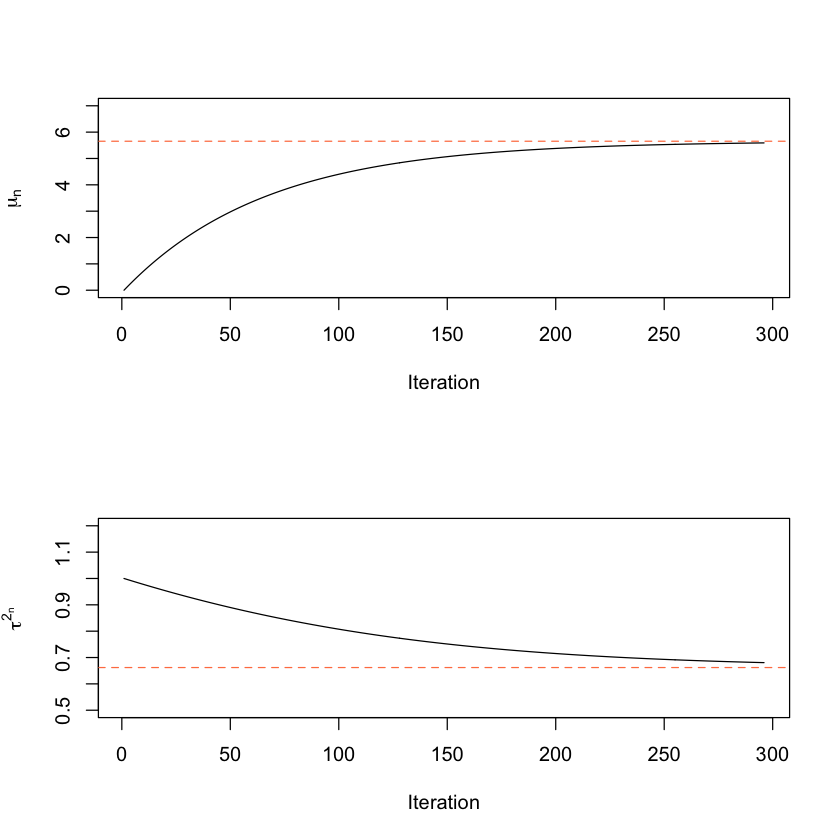

In [6]:
par(mfrow=c(2,1), bg="white")
plot(param_n[,1], type="l", ylim=c(0,7), ylab=expression(mu[n]), xlab="Iteration")
abline(h=mu_n, lty=2, col="coral")

plot(param_n[,2], type="l", ylim=c(0.5,1.2), ylab=expression(tau^2[n]), xlab="Iteration")
abline(h=tausq_n, lty=2, col="coral")